<a href="https://colab.research.google.com/github/rus4787/Business-evaluation-of-the-product/blob/main/Marina_hypotez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Гипотеза увеличения суммы чека до 6000

In [ ]:
import time
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [ ]:
table_clien = joblib.load('/content/drive/MyDrive/barnaul_analitic/base/df_table_client.joblib')
data_nom =pd.read_parquet(f'/content/drive/MyDrive/barnaul_analitic/base/marina_table_price_nomenklatura.parquet')
table = joblib.load('/content/drive/MyDrive/barnaul_analitic/base/df_organizations_all.joblib')

In [ ]:
data_nom['дата_счета'] = pd.to_datetime(data_nom['дата_счета'])
data_nom['дата_оплаты'] = pd.to_datetime(data_nom['дата_оплаты'])
data_nom.head(1)

,идентификатор,номер_счета,номенклатура,тип_пакета,количество_удостоверений,цена_за_удостоверение,сумма_за_удостоверение,решение_об_оплате,номер_менеджера,фио_менеджера,...,тип_номенклатуры,код_номенклатуры,наименование_региона,расшифровка_оквэд,вид_деятельности,дата_счета,дата_оплаты,сумма,год_оплаты,месяц_оплаты
0,65292821,38039332,173. Экология,None,1,0,0,отказ,1153,Абдуразакова Елена Ивановна,...,по направлению,173,не установлен,не установлен,Не определено,2021-09-06,2021-09-06,0.0,2021.0,9.0


In [ ]:
df_nom = data_nom[data_nom['дата_счета'] > pd.to_datetime('2020-12-31')]

## Сгруппировка таблиц и добавить необходимые колонки

In [ ]:
result = df_nom.merge(table[['inn', 'оквэд']], left_on='инн_организации', right_on='inn', how='left')

In [ ]:
df_hypotez_1 = result[['номер_счета', 'дата_счета', 'сумма', 'тип_номенклатуры',
                       'количество_удостоверений', 'цена_за_удостоверение',
                       'инн_организации', 'оквэд', 'решение_об_оплате']]
df_hypotez_2 = result[['номер_счета', 'дата_счета', 'сумма', 'тип_номенклатуры',
                       'количество_удостоверений', 'цена_за_удостоверение',
                       'инн_организации', 'оквэд', 'решение_об_оплате']]

In [ ]:
df_hypotez_1['год_счета'] = df_hypotez_1['дата_счета'].dt.year
df_hypotez_2['год_счета'] = df_hypotez_2['дата_счета'].dt.year

<ipython-input-105-8d41bf278df7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hypotez_1['год_счета'] = df_hypotez_1['дата_счета'].dt.year
<ipython-input-105-8d41bf278df7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hypotez_2['год_счета'] = df_hypotez_2['дата_счета'].dt.year


In [ ]:
df_hypotez_1['оквэд'] = df_hypotez_1['оквэд'].astype('str')
df_hypotez_1['бюджет'] = df_hypotez_1['оквэд'].apply(lambda x: 1 if x is not None and (x.startswith('85.') or x.startswith('84.')) else 0)
df_hypotez_2['оквэд'] = df_hypotez_2['оквэд'].astype('str')
df_hypotez_2['бюджет'] = df_hypotez_2['оквэд'].apply(lambda x: 1 if x is not None and (x.startswith('85.') or x.startswith('84.')) else 0)

<ipython-input-106-12e320ef7a0f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hypotez_1['оквэд'] = df_hypotez_1['оквэд'].astype('str')
<ipython-input-106-12e320ef7a0f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hypotez_1['бюджет'] = df_hypotez_1['оквэд'].apply(lambda x: 1 if x is not None and (x.startswith('85.') or x.startswith('84.')) else 0)
<ipython-input-106-12e320ef7a0f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

 оставим данные только за 2023 и 2024 года, пересчитаем суммы для бюджетных организаций, установим новую сумму в 0 для всех счетов, кроме бюджетных, если сумма меньше 6000, и пересчитаем конверсию с учетом увеличения количества пакетов на 15%

In [ ]:
# Фильтрация данных за 2023 и 2024 года
df_hypotez_1 = df_hypotez_1[(df_hypotez_1['год_счета'] == 2023) | (df_hypotez_1['год_счета'] == 2024)]
df_hypotez_1['дата_счета'] = pd.to_datetime(df_hypotez_1['дата_счета'])
df_hypotez_1['месяц'] = df_hypotez_1['дата_счета'].dt.month
df_hypotez_2['дата_счета'] = pd.to_datetime(df_hypotez_2['дата_счета'])
df_hypotez_2['месяц'] = df_hypotez_2['дата_счета'].dt.month

<ipython-input-107-dfc748b704c5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hypotez_1['дата_счета'] = pd.to_datetime(df_hypotez_1['дата_счета'])
<ipython-input-107-dfc748b704c5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hypotez_1['месяц'] = df_hypotez_1['дата_счета'].dt.month
<ipython-input-107-dfc748b704c5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

In [ ]:
df_hypotez_1.head()

,номер_счета,дата_счета,сумма,тип_номенклатуры,количество_удостоверений,цена_за_удостоверение,инн_организации,оквэд,решение_об_оплате,год_счета,бюджет,месяц
71,44958324,2023-06-16,0.0,по направлению,1,0,4632162469,не установлен,отказ,2023,0,6
72,44958324,2023-06-16,0.0,по направлению,1,0,4632162469,не установлен,отказ,2023,0,6
73,44959640,2023-06-28,0.0,по направлению,3,0,6007003700,55.90,отказ,2023,0,6
74,44959640,2023-06-28,0.0,по направлению,1,0,6007003700,55.90,отказ,2023,0,6
75,44959640,2023-06-28,0.0,по направлению,2,0,6007003700,55.90,отказ,2023,0,6


Групируем под старые данные

In [ ]:
# Группировка по месяцу и году
grouped_old = df_hypotez_1.groupby(['год_счета', 'месяц']).agg({
    'сумма': 'sum',
    'решение_об_оплате': lambda x: (x == 'оплачено').sum() / len(x)
}).reset_index()

grouped_old.rename(columns={'новая_сумма': 'сумма_за_месяц', 'решение_об_оплате': 'конверсия'}, inplace=True)

In [ ]:
grouped_old.head(2)

,год_счета,месяц,сумма,конверсия
0,2023,1,62110097.0,0.738943
1,2023,2,66619219.0,0.725236


Групируем под новые данные

In [ ]:
# Пересчет суммы для бюджетных организаций
df_hypotez_1['новая_сумма'] = df_hypotez_1.apply(
    lambda row: row['количество_удостоверений'] * 500 if row['бюджет'] == 1 else row['сумма'],
    axis=1
)
# Установка новой суммы в 0 для всех счетов, кроме бюджетных, если сумма меньше 6000
df_hypotez_1['новая_сумма'] = df_hypotez_1.apply(
    lambda row: 0 if row['бюджет'] != 1 and row['сумма'] < 6000 else row['новая_сумма'],
    axis=1
)
# Группировка по месяцу и году
grouped_new = df_hypotez_1.groupby(['год_счета', 'месяц']).agg({
    'новая_сумма': 'sum',
    'решение_об_оплате': lambda x: (x == 'оплачено').sum() / len(x)
}).reset_index()

grouped_new.rename(columns={'новая_сумма': 'сумма', 'решение_об_оплате': 'конверсия'}, inplace=True)

In [ ]:
grouped_new.head()

,год_счета,месяц,сумма,конверсия
0,2023,1,46309984.0,0.738943
1,2023,2,52717106.0,0.725236
2,2023,3,66475277.0,0.738250
3,2023,4,79665315.0,0.766660
4,2023,5,78339391.0,0.790698


##  Проверка гипотезы с использованием p-value (без предсказания просто на измененых данных) - т.е. что бы было сейчас при таких условиях

In [ ]:
from scipy import stats

# Проверка среднего чека
mean_check = grouped_new['сумма'].mean()
std_check = grouped_new['сумма'].std()
n_check = len(grouped_new)

t_stat_check, p_value_check = stats.ttest_1samp(grouped_new['сумма'], 35000)
print(f"Средний чек: {round(mean_check,2)}, p-value: {p_value_check}")

# Проверка конверсии
mean_conversion = grouped_new['конверсия'].mean()
std_conversion = grouped_new['конверсия'].std()
n_conversion = len(grouped_new)

z_stat_conversion, p_value_conversion = stats.ttest_1samp(grouped_new['конверсия'], 0.8)
print(f"Конверсия: {round(mean_conversion, 2)}, p-value: {round(p_value_conversion, 6)}")

Средний чек: 59738041.95, p-value: 1.6728380355149155e-11
Конверсия: 0.84, p-value: 0.093133


Средний чек: Средний чек составляет 59 738 041.95, и p-value очень маленькое (1.6e-16), что значительно меньше 0.05. Это означает, что средний чек значительно отличается от целевого значения 35,000, и мы можем отвергнуть нулевую гипотезу о том, что средний чек равен 35,000.

Конверсия: Средняя конверсия составляет 0.84, и p-value равно 0.093133, что больше 0.05. Это означает, что конверсия незначительно отличается от целевого значения 0.8, и мы не можем отвергнуть нулевую гипотезу о том, что конверсия равна 0.8.

По русски:
- Средний чек: у нас он получится значительно выше целевого значения 35,000. Это может означать, что ваши изменения в ценах и типах номенклатуры привели к значительному увеличению среднего чека. Возможно, стоит пересмотреть стратегию ценообразования или структуру пакетов, чтобы приблизиться к целевому значению.
- Конверсия: у нас будет конверсия близка к целевому значению 0.8, и статистически значимое отличие не обнаружено. Это хороший результат, и  изменения, вероятно, не привели к значительному ухудшению конверсии

Вроде бы хорошо, но: этот результат может быть нереалистичным или нежелательным в контексте продаж: если средний чек слишком высок, это может привести к другим проблемам, таким как снижение количества продаж или потеря клиентов из-за высоких цен.

###  парный t-тест

In [ ]:
# Проверка среднего чека
t_stat_check, p_value_check = stats.ttest_rel(grouped_new['сумма'], grouped_old['сумма'])
print(f"Средний чек: t-statistic: {t_stat_check}, p-value: {p_value_check}")

Средний чек: t-statistic: -10.491417663812843, p-value: 2.416836041572764e-09


### тест Уилкоксона для зависимых выборок.

In [ ]:
# Проверка среднего чека
stat_check, p_value_check = stats.wilcoxon(grouped_new['сумма'], grouped_old['сумма'])
print(f"Средний чек: statistic: {stat_check}, p-value: {p_value_check}")

Средний чек: statistic: 0.0, p-value: 0.0001318338889828333


**существует статистически значимое различие между средними чеками до и после повышения минимального счета.**

### функции для ответа

In [ ]:
def calculate_low_high_contracts(df, target_mean_check, target_conversion):
    low_contracts = df[(df['бюджет'] == 1) & (df['тип_номенклатуры'] == 'по направлению')]
    high_contracts = df[(df['сумма'] >= 6000)]

    low_contracts_count = len(low_contracts)
    high_contracts_count = len(high_contracts)

    return low_contracts_count, high_contracts_count

low_contracts_count, high_contracts_count = calculate_low_high_contracts(df_hypotez_1, 35000, 0.8)
print(f"Количество низких договоров: {low_contracts_count}, Количество дорогих договоров: {high_contracts_count}")

Количество низких договоров: 22925, Количество дорогих договоров: 62827


 Расчет конверсии по месяцам и по каждому типу номенклатуры отдельно

In [ ]:
df = df_hypotez_1[['тип_номенклатуры', 'решение_об_оплате', 'месяц']]

# Расчет общей конверсии по месяцам
total_conversion_by_month = df.groupby('месяц').agg({
    'решение_об_оплате': lambda x: (x == 'оплачено').sum() / len(x)
}).reset_index()

total_conversion_by_month.rename(columns={'решение_об_оплате': 'общая_конверсия'}, inplace=True)
total_conversion_by_month['ожидаемая_конверсия'] = total_conversion_by_month['общая_конверсия'] * 0.9

# Расчет конверсии по каждому типу номенклатуры отдельно
conversion_by_type_and_month = df.groupby(['месяц', 'тип_номенклатуры']).agg({
    'решение_об_оплате': lambda x: (x == 'оплачено').sum() / len(x)
}).reset_index()

conversion_by_type_and_month.rename(columns={'решение_об_оплате': 'конверсия'}, inplace=True)

print("Общая конверсия по месяцам:")
display(total_conversion_by_month)

print("\nКонверсия по каждому типу номенклатуры отдельно:")
display(conversion_by_type_and_month)

Общая конверсия по месяцам:


,месяц,общая_конверсия,ожидаемая_конверсия
0,1,0.833911,0.750520
1,2,0.835493,0.751944
2,3,0.831911,0.748720
3,4,0.859199,0.773279
4,5,0.869309,0.782379
5,6,0.829597,0.746637
6,7,0.780643,0.702579
7,8,0.768436,0.691593
8,9,0.745608,0.671047
9,10,0.764847,0.688362



Конверсия по каждому типу номенклатуры отдельно:


,месяц,тип_номенклатуры,конверсия
0,1,пакет,0.750000
1,1,по направлению,0.834273
2,2,пакет,0.571429
3,2,по направлению,0.836874
4,3,пакет,0.625000
5,3,по направлению,0.832638
6,4,пакет,0.695652
7,4,по направлению,0.860043
8,5,пакет,0.765957
9,5,по направлению,0.869884


Увеличение количества пакетов на 15% и уменьшение количества 'по направлению'

In [ ]:
print("\nИзмененное количество строк по месяцам и типам номенклатуры:")
adjusted_quantities)


Измененное количество строк по месяцам и типам номенклатуры:


,месяц,тип_номенклатуры,количество
0,1,пакет,41.40
1,1,по направлению,7083.05
2,2,пакет,56.35
3,2,по направлению,7961.95
4,3,пакет,36.80
5,3,по направлению,7740.10
6,4,пакет,52.90
7,4,по направлению,7579.45
8,5,пакет,54.05
9,5,по направлению,7185.90


In [ ]:
import matplotlib.pyplot as plt

def analyze_differences(grouped_new, grouped_old):
    # Объединение данных по месяцам
    merged_data = pd.merge(grouped_new, grouped_old, on=['год_счета', 'месяц'], suffixes=('_new', '_old'))

    # График различий по средней сумме
    plt.figure(figsize=(12, 6))
    bar_width = 0.35
    indices = merged_data['месяц']

    plt.bar(indices - bar_width/2, merged_data['сумма_new'], bar_width, label='Новая средняя сумма', alpha=0.8)
    plt.bar(indices + bar_width/2, merged_data['сумма_old'], bar_width, label='Старая средняя сумма', alpha=0.8)

    plt.xlabel('Месяц')
    plt.ylabel('Средняя сумма')
    plt.title('Различия в средней сумме по месяцам')
    plt.xticks(indices)
    plt.legend()
    plt.show()

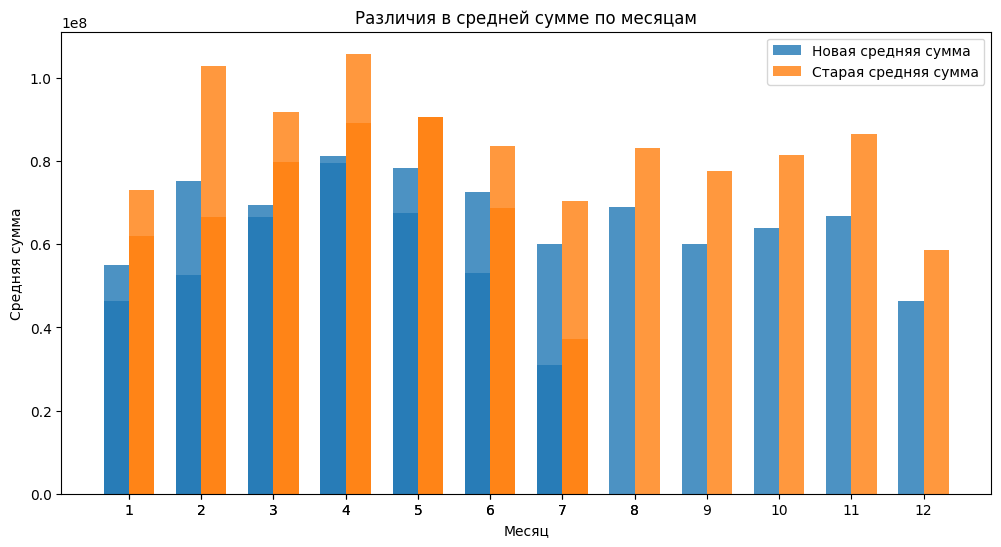

In [ ]:
analyze_differences(grouped_new, grouped_old)

✅ **Для Марины**

Это если бы было сейчас: чеков до 6000 нет, и продажа по 500 образовалкам.

## ГИПОТЕЗА ПО ОКВЭД

##  Проверка гипотезы с использованием p-value (модель предсказания)

In [ ]:
df_hypotez_2.head()

,номер_счета,дата_счета,сумма,тип_номенклатуры,количество_удостоверений,цена_за_удостоверение,инн_организации,оквэд,решение_об_оплате,год_счета,бюджет,месяц
0,38039332,2021-09-06,0.0,по направлению,1,0,1637003354,не установлен,отказ,2021,0,9
1,38039477,2021-09-06,0.0,по направлению,1,0,5718004603,nan,отказ,2021,0,9
2,38040053,2021-09-06,0.0,по направлению,1,0,3016026553,85.11,отказ,2021,1,9
3,38041673,2021-04-05,3100.0,по направлению,2,1550,7418009555,85.11,оплачено,2021,1,4
4,38041918,2021-04-26,6380.0,по направлению,2,3190,2366010572,33.13,оплачено,2021,0,4
